In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import math
from numpy import vstack,array 
from numpy.random import rand
import numpy as np 
from scipy.cluster.vq  import kmeans,vq 
import pandas as pd 
from math import sqrt 
from sklearn.cluster import KMeans 
from matplotlib import pyplot as plt 
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from pycop import archimedean, estimation, mixture, gaussian, empirical
from statsmodels.distributions.empirical_distribution import ECDF
import sympy as sp
from sympy import symbols, diff
from scipy.stats import norm, multivariate_normal
from scipy.special import erfinv
from pycop.bivariate.copula import copula
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
import empyrical as ep

In [2]:
# Preliminaries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# disable warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# all the usual copula cdf and pdf equation
def clayton_pdf(u, v, param):
    term1 = (param + 1) * (u * v) ** (-param - 1)
    term2 = (u ** (-param) + v ** (-param) - 1) ** (-2 - 1 / param)
    return term1 * term2

def clayton_cdf(u, v, param):
    return (u ** (-param) + v ** (-param) - 1) ** (-1 / param)

def gumbel_pdf(u,v,param):
    term1 = (u*v)**(-1)
    tmp = (-sp.log(u))** param + (-sp.log(v))** param
    term2 = tmp ** (-2 + 2.0 / param)
    term3 = (sp.log(u) * sp.log(v)) ** (param - 1)
    term4 = 1 + (param - 1) *  (tmp ** (-1 / param))
    return gumbel_cdf(u,v, param) * term1 * term2 * term3 * term4

def gumbel_cdf(u, v, param):
    return sp.exp(-((-sp.log(u)) ** param + (-sp.log(v)) ** param ) ** (1 / param))

def frank_pdf(u,v, param):
    term1 = param * (1 - sp.exp(-param)) * sp.exp(-param * (u + v))
    term2 = (1 - sp.exp(-param) - (1 - sp.exp(-param * u)) \
                    * (1 - sp.exp(-param * v))) ** 2
    return term1 / term2

def frank_cdf(u,v,param):
    a = (sp.exp(-param * u) - 1) * (sp.exp(-param * v) - 1)
    return (-1 / param) * sp.log(1 + a / (sp.exp(-param) - 1))

def joe_pdf(u,v,param):
    u_ = (1 - u) ** param
    v_ = (1 - v) ** param
    term1 = (u_ + v_ - u_ * v_) ** (-2 + 1 / param)
    term2 = ((1 - u) ** (param - 1)) * ((1 - v) ** (param - 1))
    term3 = param - 1 + u_ + v_ + u_ * v_
    return term1 * term2 * term3

def joe_cdf(u,v,param):
    u_ = (1 - u) ** param
    v_ = (1 - v) ** param
    return 1 - (u_ + v_ - u_ * v_) ** (1 / param)

def galambos_pdf(u,v,param):
    x = -sp.log(u)
    y = -sp.log(v)
    term1 = galambos_cdf(u, v, param) / (v * u)
    term2 = 1 - ((x ** (-param) + y ** (-param)) ** (-1 - 1 / param)) \
                    * (x ** (-param - 1) + y ** (-param - 1))
    term3 = ((x ** (-param) + y ** (-param)) ** (-2 - 1 / param)) \
                    * ((x * y) ** (-param - 1))
    term4 = 1 + param + ((x ** (-param) + y ** (-param)) ** (-1 / param))
    return term1 * term2 + term3 * term4

def galambos_cdf(u,v,param):
    return u * v * sp.exp(((-sp.log(u)) ** (-param[0]) + (-sp.log(v)) ** (-param[0])) ** (-1 / param[0]) )

def fgm_pdf(u,v,param):
    return 1 + param * (1 - 2 * u) * (1 - 2 * v)

def fgm_cdf(u,v,param):
    return u * v * (1 + param * (1 - u) * (1 - v))

def plackett_pdf(u,v,param):
    eta = (param - 1)
    term1 = param * (1 + eta * (u + v - 2 * u * v))
    term2 = (1 + eta * (u + v)) ** 2 
    term3 = 4 * param * eta * u * v
    return term1 / (term2 - term3) ** (3 / 2)

def plackett_cdf(u,v,param):
    eta = param - 1
    term1 = 0.5 * eta ** -1
    term2 = 1 + eta * (u + v)
    term3 = (1 + eta * (u + v)) ** 2
    term4 = 4 * param * eta * u * v
    return term1 * (term2 - (term3 - term4) ** 0.5)

def rclayton_pdf(u,v,param):
    return clayton_pdf(1-u,1-v,param)

def rclayton_cdf(u,v,param):
    return (u + v - 1 + clayton_cdf((1 - u),(1 - v), param) )

def gaussian_pdf(u,v,param):
    rho = param
    a = np.sqrt(2) * erfinv(2 * u - 1)
    b = np.sqrt(2) * erfinv(2 * v - 1)
    det_rho = 1 - rho**2
    return det_rho**-0.5 * sp.exp(-((a**2 + b**2) * rho**2 -2 * a * b * rho) / (2 * det_rho))

def gaussian_cdf(u,v,param):
    y1 = norm.ppf(u, 0, 1)
    y2 = norm.ppf(v, 0, 1)
    rho = param
    return multivariate_normal.cdf((y1,y2), mean=None, cov=[[1, rho], [rho, 1]])

def scad_derivative(beta_hat, lambda_val, a_val):
    if abs(beta_hat) <= lambda_val:
        return lambda_val
    elif lambda_val < abs(beta_hat) <= a_val* lambda_val:
        return ((a_val*lambda_val) - beta_hat)/(a_val-1)
    elif abs(beta_hat) > a_val*lambda_val:
        return 0

## Train

In [4]:
# import data
root = 'C:/Users/Allen/Desktop/IAQF/Data/'
all_data = pd.read_csv(root + 'merged_all_data.csv', index_col='Date', parse_dates=True).iloc[:-414,:]

pair_name = ['RUT', 'N225']
target = pair_name[0]
feature = pair_name[1]
dfx = all_data[feature]
dfy = all_data[target]
df = all_data[[feature, target]]
ret = df.copy(deep=True)

#x=feature=spy

In [5]:
ecdf_x = ECDF(dfx)
ecdf_y = ECDF(dfy)

In [6]:
df['X_uniform'] = ecdf_x(dfx) # convert the price distribution to uniform distribution based on ecdf
df['Y_uniform'] = ecdf_y(dfy)
df['X_uniform'] = df['X_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])
df['Y_uniform'] = df['Y_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])


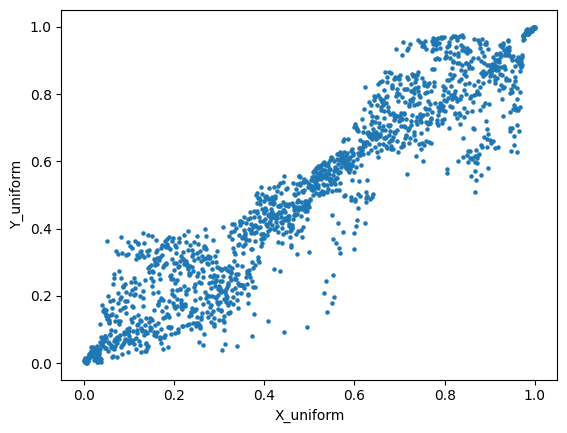

In [7]:
ax1 = df.plot.scatter(x='X_uniform',y='Y_uniform',s=5)

In [8]:
data = df[pair_name].T.values
cop = archimedean(family="clayton")
param1, cmle = estimation.fit_cmle(cop, data, opti_method='Powell')
print("Estimated parameter: ", param1[0]) 

Estimated parameter:  3.7920443188476436


In [9]:
cop = archimedean(family="gumbel")
param2, cmle = estimation.fit_cmle(cop, data, opti_method='Powell')
print("Estimated parameter: ", param2[0])

Estimated parameter:  3.752902773118592


In [10]:
cop = archimedean(family="joe")
param3, cmle = estimation.fit_cmle(cop, data, opti_method='Powell')
print("Estimated parameter: ", param3[0])

Estimated parameter:  3.983836188896417


In [11]:
# initial values of theta for each copula are generated above to calculate the E-step

## Finding Thetas and Parameters

In [12]:
# If pycop failed, continue with numerical estimation

In [13]:
try:
    cop = mixture(["clayton", "gumbel", "joe"])
    data = df[pair_name].T.values

    param, mle = estimation.fit_cmle_mixt(cop, data)
    w1 = param[0]
    w2 = param[1]
    w3 = param[2]
    theta1 = param[3]
    theta2 = param[4]
    theta3 = param[5]
except:
    lamda = 0.1  #variables in penalty term, may need to optimize
    alpha = 100000
    w1 = 0.333 # assign initial w1,w2,w3 and try to converge w1 first
    w2 = 0.333
    w3 = 0.334
    theta1 = param1[0]
    theta2 = param2[0]
    theta3 = param3[0]
    
    logsum1 = 0
    ## use sympy package to find out the derivative of the pdf of clayton copula
    x, y, z = symbols('x y z', real = True)
    f = rclayton_pdf(x, y, z)
    dfdz = diff(f,z)

    a = symbols('a', real = True)
    for i in range(len(df)):
        logsum1 = logsum1 + w1*dfdz.subs([(x, df['X_uniform'][i]),(y, df['Y_uniform'][i]),(z,a)]) / (w1*rclayton_pdf(df['X_uniform'][i],df['Y_uniform'][i],a) + w2*gumbel_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta2) + w3*joe_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta3))
    f1 = logsum1
    dfdtheta1 = diff(f1 , a) #f'(theta)
    
    logsum2 = 0
    x, y, z = symbols('x y z', real = True)
    f = gumbel_pdf(x, y, z)
    dfdz = diff(f,z)
    
    a = symbols('a', real = True)
    for i in range(len(df)):
        logsum2 = logsum2 + w2*dfdz.subs([(x, df['X_uniform'][i]),(y, df['Y_uniform'][i]),(z,a)]) / (w1*rclayton_pdf(df['X_uniform'][i],df['Y_uniform'][i],a) + w2*gumbel_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta2) + w3*joe_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta3))
    f2 = logsum2
    dfdtheta2 = diff(f2 , a)
    
    logsum3 = 0
    x, y, z = symbols('x y z', real = True)
    f = joe_pdf(x, y, z)
    dfdz = diff(f,z)
    
    a = symbols('a', real = True)
    for i in range(len(df)):
        logsum3 = logsum3 + w3*dfdz.subs([(x, df['X_uniform'][i]),(y, df['Y_uniform'][i]),(z,a)]) / (w1*rclayton_pdf(df['X_uniform'][i],df['Y_uniform'][i],a) + w2*gumbel_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta2) + w3*joe_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta3))
    f3 = logsum3
    dfdtheta3 = diff(f3 , a)

    
    iteration = 0
    for j in range(3):
        iteration += 1
        print(iteration, 'Round of Iteration')
        sumterm = 0
        wisumterm = 0
        for i in range(1000):
            for t in range(len(df)):
                sumterm = sumterm + (w1 * rclayton_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta1))/(w1*rclayton_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta1) + w2*gumbel_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta2) + w3*joe_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta3))
            wisumterm = w1*scad_derivative(w1,lamda,alpha) + w2*scad_derivative(w2,lamda,alpha) + w3*scad_derivative(w3,lamda,alpha) - 1
            w1_new = (w1*scad_derivative(w1, lamda, alpha) - sumterm/len(df)) / wisumterm
            print('Weight 1 is converging: ', w1_new)
            if abs(w1_new - w1) <= 0.000001:
                w1 = w1_new
                sumterm = 0
                wisumterm = 0
                break
            else:
                sumterm = 0
                wisumterm = 0
                w1 = w1_new
    
    
        for i in range(1000):
            for t in range(len(df)):
                sumterm = sumterm + (w2 * gumbel_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta2))/(w1*rclayton_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta1) + w2*gumbel_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta2) + w3*joe_pdf(df['X_uniform'][t],df['X_uniform'][t],theta3))
            wisumterm = w1*scad_derivative(w1,lamda,alpha) + w2*scad_derivative(w2,lamda,alpha) + w3*scad_derivative(w3,lamda,alpha) -1
            w2_new = (w2*scad_derivative(w2, lamda, alpha) - sumterm/len(df)) / wisumterm
            print('Weight 2 is converging: ', w2_new)
            if abs(w2_new - w2) <= 0.000001:
                sumterm = 0
                wisumterm = 0
                w2 = w2_new
                break
            else:
                sumterm = 0
                wisumterm = 0
                w2 = w2_new
        w3 = 1 - w1 - w2
    
     
        for i in range(1000): # iterate 1000times using NR methond to find theta of first copula
            theta1_new = theta1 - f1.subs([(a,theta1)]) / dfdtheta1.subs([(a,theta1)])
            print('Theta1 is converging: ' , theta1_new)
            if abs(theta1_new - theta1) <= 0.000001:
                theta1 = theta1_new
                break
            else:
                theta1 = theta1_new
    
    
    
    
        for i in range(1000):
            theta2_new = theta2 - f2.subs([(a,theta2)]) / dfdtheta2.subs([(a,theta2)])
            print('Theta2 is converging: ' , theta2_new)
            if abs(theta2_new - theta2) <= 0.000001:
                theta2 = theta2_new
                break
            else:
                theta2 = theta2_new
    
    
    
    
        for i in range(1000):
            theta3_new = theta3 - f3.subs([(a,theta3)]) / dfdtheta3.subs([(a,theta3)])
            print('Theta3 is converging: ' , theta3_new)
            if abs(theta3_new - theta3) <= 0.000001:
                theta3 = theta3_new
                break
            else:
                theta3 = theta3_new

method: SLSQP - success: True : Optimization terminated successfully


In [14]:
w1, w2, w3, theta1, theta2, theta3

(0.3673557429531916,
 0.3313010463359965,
 0.30134321071081194,
 6.344362121612672,
 4.146349215310191,
 12.174605235671596)

In [15]:
# weight*sp.exp(-((-sp.log(x))**theta_gumbel+(-sp.log(y))**theta_gumbel)**(1/theta_gumbel))   <--- gumbel part
# weight*sp.log(sp.exp(sp.log((sp.exp(-theta*x)-1)/(sp.exp(-theta)-1))+sp.log((sp.exp(-theta*y)-1)/(sp.exp(-theta)-1)))*(sp.exp(-theta)-1)+1)/(theta)  <--- Frank Part
# weight*(((x**(-theta)-1)/theta + (y**(-theta)-1)/theta)*theta + 1)**(-1/theta)   <--- Clayton Part
# weight*(1-(1-(sp.exp((sp.log(1-(1-x)**theta))+sp.log(1-(1-x)**theta)))**(1/theta)))  <-- Joe Part

## Finalize Mixed Copula

In [16]:
x,y = symbols('x y', real = True) # finding the partial dirivative of the copula function
f = w1*clayton_cdf(x,y,theta1) + w2*gumbel_cdf(x,y,theta2) + w3*joe_cdf(x,y,theta3)
dfdx = diff(f, x) # partial derivative of Copula function with respect to x
dfdy = diff(f, y) # partial derivative of Copula function with respect to x

In [17]:
df['dfdx'] = " "
df['dfdy'] = " "
for i in range(len(df)): # substitue the uniform of two assets to the partial derivative function
    df['dfdx'][i] = dfdx.subs([(x,df['X_uniform'][i]),(y,df['Y_uniform'][i])])
    df['dfdy'][i] = dfdy.subs([(x,df['X_uniform'][i]),(y,df['Y_uniform'][i])])

## Trading Strategy

In [18]:
upthreshold = 0.65
lowerthreshold = 0.35
exitthreshold = 0.5

def generate_signal(df):
    df['X_position'] = " "
    or_and = 'or'
    if or_and == 'or':
        if df['dfdx'][0] >= upthreshold or df['dfdy'][0]<= lowerthreshold:
            df['X_position'][0] = 1
        elif df['dfdx'][0] <= lowerthreshold or df['dfdy'][0]>= upthreshold:
            df['X_position'][0] = -1
        else:
            df['X_position'][0] = 0

        for i in range(1,len(df)):
            if df['X_position'][i-1] == 0:
                if df['dfdx'][i] >= upthreshold or df['dfdy'][i]<= lowerthreshold:
                    df['X_position'][i] = 1
                elif df['dfdx'][i] <= lowerthreshold or df['dfdy'][i]>= upthreshold:
                    df['X_position'][i] = -1
                else:
                    df['X_position'][i] = 0
            elif df['X_position'][i-1] == 1:
                if df['dfdy'][i] >= exitthreshold or df['dfdx'][i] <= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = 1
            elif df['X_position'][i-1] == -1:
                if df['dfdy'][i] <= exitthreshold or df['dfdx'][i] >= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = -1
    else:
        if df['dfdx'][0] >= upthreshold and df['dfdy'][0]<= lowerthreshold:
            df['X_position'][0] = 1
        elif df['dfdx'][0] <= lowerthreshold and df['dfdy'][0]>= upthreshold:
            df['X_position'][0] = -1
        else:
            df['X_position'][0] = 0

        for i in range(1,len(df)):
            if df['X_position'][i-1] == 0:
                if df['dfdx'][i] >= upthreshold and df['dfdy'][i]<= lowerthreshold:
                    df['X_position'][i] = 1
                elif df['dfdx'][i] <= lowerthreshold and df['dfdy'][i]>= upthreshold:
                    df['X_position'][i] = -1
                else:
                    df['X_position'][i] = 0
            elif df['X_position'][i-1] == 1:
                if df['dfdy'][i] >= exitthreshold and df['dfdx'][i] <= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = 1
            elif df['X_position'][i-1] == -1:
                if df['dfdy'][i] <= exitthreshold and df['dfdx'][i] >= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = -1
    df['Y_position'] = 0 - df['X_position']
    return None

In [19]:
generate_signal(df)

<AxesSubplot: xlabel='Date'>

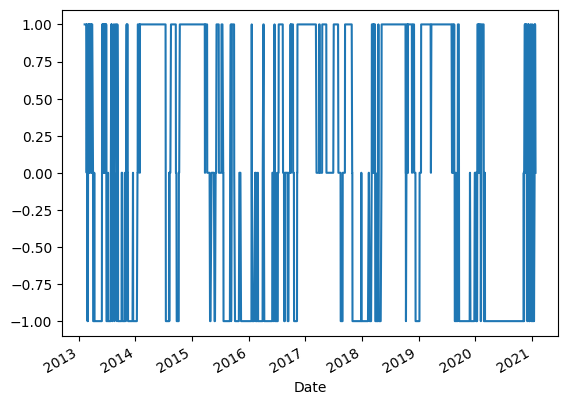

In [20]:
df['X_position'].plot()

<AxesSubplot: xlabel='Date'>

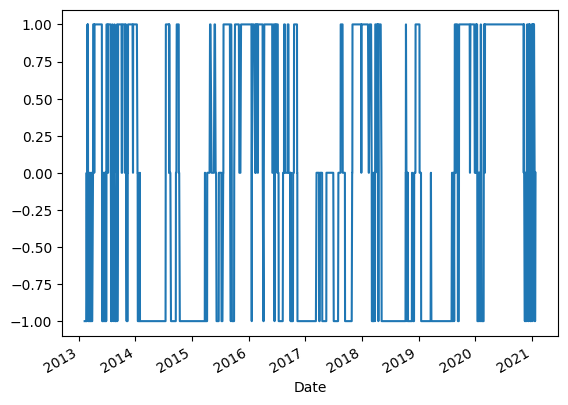

In [21]:
df['Y_position'].plot()

In [22]:
df

,N225,RUT,X_uniform,Y_uniform,dfdx,dfdy,X_position,Y_position
Date,,,,,,,,
2013-02-07,121.550496,908.099976,0.003643,0.004250,0.348908998478418,0.157478209990859,1,-1
2013-02-08,119.115694,913.669983,0.000607,0.006679,0.598745305422085,0.00758151444713522,1,-1
2013-02-14,121.249900,923.760010,0.002429,0.012143,0.599501755595723,0.0220910567915283,1,-1
2013-02-15,120.204288,923.150024,0.001214,0.010322,0.614465581276094,0.0113933604046909,1,-1
2013-02-19,121.434487,932.000000,0.003036,0.015786,0.622038533081029,0.0228519459829398,1,-1
...,...,...,...,...,...,...,...,...
2021-01-19,276.110239,2151.139893,0.997571,0.997571,0.716155223643649,0.716155223643649,0,0
2021-01-20,274.533999,2160.620117,0.996357,0.998786,0.994201519542559,0.368015032234068,1,-1
2021-01-21,277.696483,2141.419922,0.999393,0.996964,0.361353277553360,0.998079949922415,0,0


In [23]:
signal = df[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
signal

,N225,RUT
Date,,
2013-02-07,1,-1
2013-02-08,1,-1
2013-02-14,1,-1
2013-02-15,1,-1
2013-02-19,1,-1
...,...,...
2021-01-19,0,0
2021-01-20,1,-1
2021-01-21,0,0


In [24]:
ret['X_ret'] = ret.iloc[:,0] / ret.iloc[:,0].shift(1) - 1
ret['Y_ret'] = ret.iloc[:,1] / ret.iloc[:,1].shift(1) - 1
ret['ratio'] = ret.iloc[:,1] / ret.iloc[:, 0]
ret

,N225,RUT,X_ret,Y_ret,ratio
Date,,,,,
2013-02-07,121.550496,908.099976,NaN,NaN,7.470969
2013-02-08,119.115694,913.669983,-0.020031,0.006134,7.670442
2013-02-14,121.249900,923.760010,0.017917,0.011043,7.618646
2013-02-15,120.204288,923.150024,-0.008624,-0.000660,7.679843
2013-02-19,121.434487,932.000000,0.010234,0.009587,7.674920
...,...,...,...,...,...
2021-01-19,276.110239,2151.139893,0.005217,0.013159,7.790873
2021-01-20,274.533999,2160.620117,-0.005709,0.004407,7.870137
2021-01-21,277.696483,2141.419922,0.011519,-0.008886,7.711369


In [25]:
signal
ret

,N225,RUT
Date,,
2013-02-07,1,-1
2013-02-08,1,-1
2013-02-14,1,-1
2013-02-15,1,-1
2013-02-19,1,-1
...,...,...
2021-01-19,0,0
2021-01-20,1,-1
2021-01-21,0,0


,N225,RUT,X_ret,Y_ret,ratio
Date,,,,,
2013-02-07,121.550496,908.099976,NaN,NaN,7.470969
2013-02-08,119.115694,913.669983,-0.020031,0.006134,7.670442
2013-02-14,121.249900,923.760010,0.017917,0.011043,7.618646
2013-02-15,120.204288,923.150024,-0.008624,-0.000660,7.679843
2013-02-19,121.434487,932.000000,0.010234,0.009587,7.674920
...,...,...,...,...,...
2021-01-19,276.110239,2151.139893,0.005217,0.013159,7.790873
2021-01-20,274.533999,2160.620117,-0.005709,0.004407,7.870137
2021-01-21,277.696483,2141.419922,0.011519,-0.008886,7.711369


In [26]:
# # function for backtest returns
# def backtest(d, ret):

    # multiply daily ret inplace of b/s, find sum of two ret for daily ret, then cumprod
#     d[f'{target}_ret'] = d[f'{target}'].shift(1) * ret['Y_ret'] 
#     d[f'{feature}_ret'] = d[f'{feature}'].shift(1) * ret['X_ret'] 
#     d['dret'] = d[f'{target}_ret'] + d[f'{feature}_ret']
#     d.dropna(inplace=True)
#     d['cumpl'] = np.cumprod(1 + d['dret'].values)
#     return d
    
def backtest(df,ret,funds=10000):
    
    initial_funds = funds
    dfx = ret.iloc[:, 0]
    dfy = ret.iloc[:, 1]
    test = df.copy()
    
    test.iloc[0,0]  = 0
    test.iloc[0,1]  = 0
    test.iloc[-1,1]  = 0
    test.iloc[-1,0]  = 0

    test['cumpl'] = " "
    test['cumpl'][0] = 0

    ratio = (dfy[0]/dfx[0])
    
    for i in range(1, len(test)):
        Xshares = funds / dfx.iloc[i]
        Yshares = funds / dfy.iloc[i]
#         if(test.iloc[i,0] - test.iloc[i-1,0] != 0):#If position change != 0, change ratio;otherwise keep it
#             ratio = (dfy[i]/dfx[i])
        test['cumpl'][i] = test['cumpl'][i-1] + (dfx[i] - dfx[i-1])*Xshares*test.iloc[i-1,0] + (dfy[i] - dfy[i-1])*Yshares*test.iloc[i-1,1]
        funds += (dfx[i] - dfx[i-1])*Xshares*test.iloc[i-1,0] + (dfy[i] - dfy[i-1])*Yshares*test.iloc[i-1,1]
    test['dret'] = test['cumpl'] / test['cumpl'].shift(1)
    test['cumpl'] = test['cumpl'] / initial_funds + 1
    return test
    

In [27]:
result = backtest(signal, ret)
result.tail()

,N225,RUT,cumpl,dret
Date,,,,
2021-01-19,0,0,14.093778,1.008399
2021-01-20,1,-1,14.093778,1.0
2021-01-21,0,0,14.380648,1.021909
2021-01-22,1,-1,14.380648,1.0
2021-01-25,0,0,14.474959,1.007048


<AxesSubplot: xlabel='Date'>

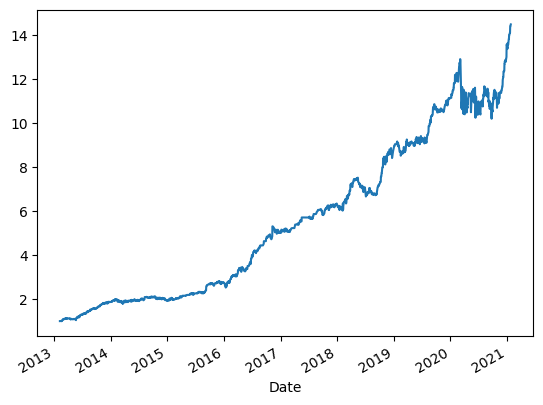

In [28]:
result['cumpl'].plot()

## Test

In [29]:
# import data
root = 'C:/Users/Allen/Desktop/IAQF/Data/'
all_data_test = pd.read_csv(root + 'merged_all_data.csv', index_col='Date', parse_dates=True).iloc[-414:,:]

df_testx = all_data_test[feature]
df_testy = all_data_test[target]
df_test = all_data_test[[feature, target]]
ret_test = df_test.copy(deep=True)


In [30]:
ret_test

,N225,RUT
Date,,
2021-01-27,276.393655,2108.699951
2021-01-28,270.756753,2106.610107
2021-01-29,265.251944,2073.639893
2021-02-01,268.336278,2126.159912
2021-02-02,270.422391,2151.439941
...,...,...
2023-01-13,202.207290,1887.030029
2023-01-17,203.697601,1884.290039
2023-01-18,208.847124,1854.359985


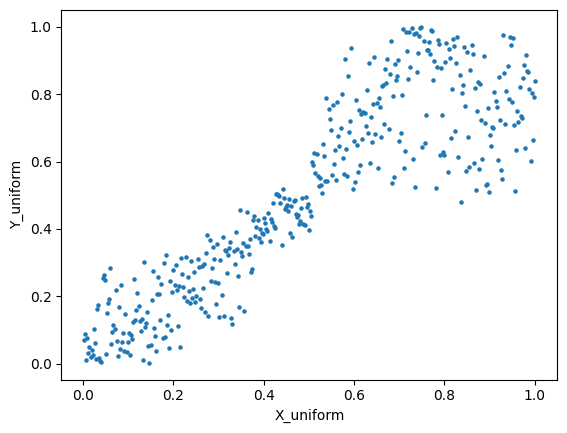

In [31]:
ecdf_x = ECDF(df_testx) #Get the empirical CDF from the given price list
ecdf_y = ECDF(df_testy)
df_test['X_uniform'] = ecdf_x(df_testx) # convert the price distribution to uniform distribution based on ecdf
df_test['Y_uniform'] = ecdf_y(df_testy)
df_test['X_uniform'] = df_test['X_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])
df_test['Y_uniform'] = df_test['Y_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])
ax1 = df_test.plot.scatter(x='X_uniform',y='Y_uniform',s=5)

In [32]:
df_test['dfdx'] = " "
df_test['dfdy'] = " "
for i in range(len(df_test)): # substitue the uniform of two assets to the partial derivative function
    df_test['dfdx'][i] = dfdx.subs([(x,df_test['X_uniform'][i]),(y,df_test['Y_uniform'][i])])
    df_test['dfdy'][i] = dfdy.subs([(x,df_test['X_uniform'][i]),(y,df_test['Y_uniform'][i])])

In [33]:
generate_signal(df_test)
df_test

,N225,RUT,X_uniform,Y_uniform,dfdx,dfdy,X_position,Y_position
Date,,,,,,,,
2021-01-27,276.393655,2108.699951,0.956522,0.512077,0.00374846112392461,0.998022014438150,-1,1
2021-01-28,270.756753,2106.610107,0.898551,0.509662,0.00619338493277008,0.994194976974141,-1,1
2021-01-29,265.251944,2073.639893,0.835749,0.480676,0.00844906003047710,0.990632850316051,-1,1
2021-02-01,268.336278,2126.159912,0.869565,0.514493,0.00904665347888974,0.990771969238963,-1,1
2021-02-02,270.422391,2151.439941,0.893720,0.533816,0.00904193639856197,0.991685206711062,-1,1
...,...,...,...,...,...,...,...,...
2023-01-13,202.207290,1887.030029,0.227053,0.316425,0.807441921700668,0.165527111862227,1,-1
2023-01-17,203.697601,1884.290039,0.253623,0.309179,0.704656001831065,0.260420502069962,1,-1
2023-01-18,208.847124,1854.359985,0.318841,0.268116,0.280338353461441,0.685633667305435,0,0


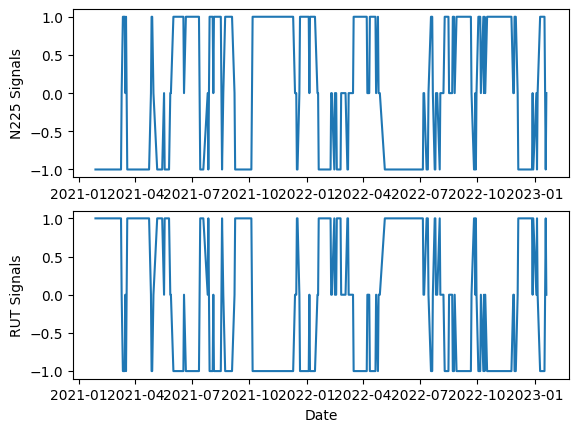

In [34]:
fig, axs = plt.subplots(2)
_ = axs[0].plot(df_test['X_position'])
_ = axs[1].plot(df_test['Y_position'])
_ =axs[0].set(ylabel=f"{feature} Signals")
_ = axs[1].set(ylabel=f"{target} Signals")
_ = plt.xlabel('Date')

In [35]:
signal_test = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
signal_test

,N225,RUT
Date,,
2021-01-27,-1,1
2021-01-28,-1,1
2021-01-29,-1,1
2021-02-01,-1,1
2021-02-02,-1,1
...,...,...
2023-01-13,1,-1
2023-01-17,1,-1
2023-01-18,0,0


In [36]:
ret_test['X_ret'] = ret_test.iloc[:,0] / ret_test.iloc[:,0].shift(1) - 1
ret_test['Y_ret'] = ret_test.iloc[:,1] / ret_test.iloc[:,1].shift(1) - 1
ret_test['ratio'] = ret_test.iloc[:,1] / ret_test.iloc[:,0]
ret_test

,N225,RUT,X_ret,Y_ret,ratio
Date,,,,,
2021-01-27,276.393655,2108.699951,NaN,NaN,7.629336
2021-01-28,270.756753,2106.610107,-0.020394,-0.000991,7.780453
2021-01-29,265.251944,2073.639893,-0.020331,-0.015651,7.817624
2021-02-01,268.336278,2126.159912,0.011628,0.025327,7.923490
2021-02-02,270.422391,2151.439941,0.007774,0.011890,7.955850
...,...,...,...,...,...
2023-01-13,202.207290,1887.030029,0.008383,0.005847,9.332156
2023-01-17,203.697601,1884.290039,0.007370,-0.001452,9.250428
2023-01-18,208.847124,1854.359985,0.025280,-0.015884,8.879031


In [37]:
result_test = backtest(signal_test, ret_test)
result_test.tail()

,N225,RUT,cumpl,dret
Date,,,,
2023-01-13,1,-1,4.02469,1.003329
2023-01-17,1,-1,4.059988,1.01167
2023-01-18,0,0,4.225624,1.05413
2023-01-19,-1,1,4.225624,1.0
2023-01-20,0,0,4.266627,1.012712


In [38]:
n_trades = len(result_test) - (signal_test == 0).astype(int).sum(axis=0)[0]
n_trades

338

In [39]:
def maxdd(s):
    hwm = s['cumpl'].cummax()
    dd = (1 + hwm)/(1 + s.cumpl) - 1
    return max(dd)


In [40]:
mdd = maxdd(result_test)
mdd

0.06331355783550041

In [41]:
win_rate = (result_test['dret'] > 1).astype(int).sum(axis=0) / n_trades
win_rate

0.5946745562130178

In [42]:
ret_test_cpy = ret_test.iloc[1:, :]

# result_test['X_adj'] = ret_test.iloc[:,0]/ret_test.iloc[1,0]
# # result_test['Y_ADJ']

In [43]:
ret_test_cpy['X_adj'] = ret_test_cpy.iloc[:,0] / ret_test_cpy.iloc[0,0]
ret_test_cpy['Y_adj'] = ret_test_cpy.iloc[:,1] / ret_test_cpy.iloc[1,1]

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Terminal Value Mutiplier')

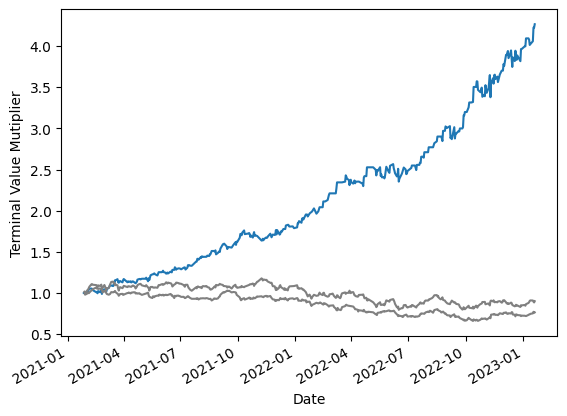

In [44]:
ax = result_test['cumpl'].plot()
ret_test_cpy.X_adj.plot(ax=ax, c='grey')
ret_test_cpy.Y_adj.plot(ax=ax, c='grey')
plt.xlabel("Date")
plt.ylabel("Terminal Value Mutiplier")

# SIGNAL 2

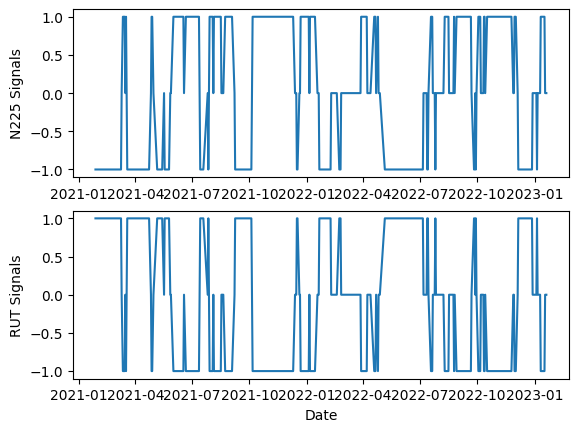

In [45]:
upthreshold = 0.75
lowerthreshold = 0.25

generate_signal(df_test)
fig, axs = plt.subplots(2)
_ = axs[0].plot(df_test['X_position'])
_ = axs[1].plot(df_test['Y_position'])

_ =axs[0].set(ylabel=f"{feature} Signals")
_ = axs[1].set(ylabel=f"{target} Signals")
_ = plt.xlabel('Date')

In [46]:
signal_test2 = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
result_test2 = backtest(signal_test2, ret_test)


In [47]:
n_trades2 = len(result_test2) - (signal_test2 == 0).astype(int).sum(axis=0)[0]
n_trades2

315

In [48]:
win_rate2 = (result_test2.dret > 1).astype(int).sum(axis=0) / n_trades2
win_rate2

0.6

In [49]:
mdd2 = maxdd(result_test2)
mdd2

0.06176150223798271

In [50]:
result_test2.tail(1)

,N225,RUT,cumpl,dret
Date,,,,
2023-01-20,0,0,3.786387,1.0


# SIGNAL 3

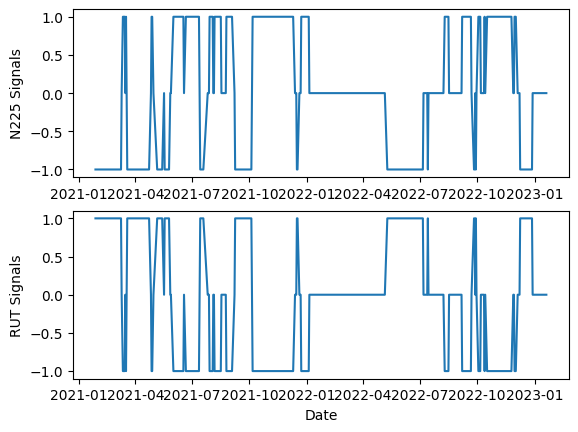

In [51]:
upthreshold = 0.85
lowerthreshold = 0.15

generate_signal(df_test)
fig, axs = plt.subplots(2)
_ = axs[0].plot(df_test['X_position'])
_ = axs[1].plot(df_test['Y_position'])

_ =axs[0].set(ylabel=f"{feature} Signals")
_ = axs[1].set(ylabel=f"{target} Signals")
_ = plt.xlabel('Date')

In [52]:
signal_test3 = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
result_test3 = backtest(signal_test3, ret_test)

In [53]:
n_trades3 = len(result_test3) - (signal_test3 == 0).astype(int).sum(axis=0)[0]
n_trades3

261

In [54]:
win_rate3 = (result_test3.dret > 1).astype(int).sum(axis=0) / n_trades3
win_rate3

0.5900383141762452

In [55]:
mdd3 = maxdd(result_test3)
mdd3

0.05665003700565485

In [56]:
result_test3.tail(1)

,N225,RUT,cumpl,dret
Date,,,,
2023-01-20,0,0,2.723349,1.0


# SIGNAL 4

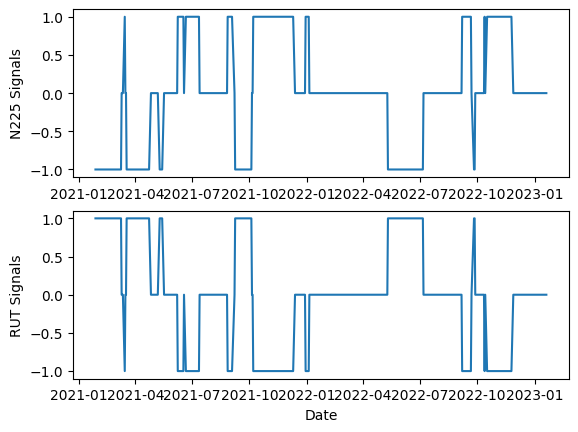

In [57]:
upthreshold = 0.95
lowerthreshold = 0.05

generate_signal(df_test)
fig, axs = plt.subplots(2)
_ = axs[0].plot(df_test['X_position'])
_ = axs[1].plot(df_test['Y_position'])

_ =axs[0].set(ylabel=f"{feature} Signals")
_ = axs[1].set(ylabel=f"{target} Signals")
_ = plt.xlabel('Date')

In [58]:
signal_test4 = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
result_test4 = backtest(signal_test4, ret_test)

In [59]:
n_trades4 = len(result_test4) - (signal_test4 == 0).astype(int).sum(axis=0)[0]
n_trades4

202

In [60]:
win_rate4 = (result_test4.dret > 1).astype(int).sum(axis=0) / n_trades4
win_rate4

0.599009900990099

In [61]:
mdd4 = maxdd(result_test4)
mdd4

0.05610725752656398

In [62]:
result_test4.tail(1)

,N225,RUT,cumpl,dret
Date,,,,
2023-01-20,0,0,2.178008,1.0


# SIGNAL 5


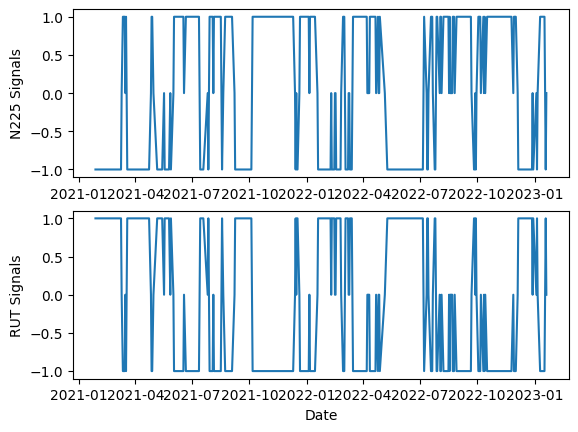

In [63]:
upthreshold = 0.55
lowerthreshold = 0.45

generate_signal(df_test)
fig, axs = plt.subplots(2)
_ = axs[0].plot(df_test['X_position'])
_ = axs[1].plot(df_test['Y_position'])

_ =axs[0].set(ylabel=f"{feature} Signals")
_ = axs[1].set(ylabel=f"{target} Signals")
_ = plt.xlabel('Date')

In [64]:
signal_test5 = df_test[['X_position', 'Y_position']].rename(columns={'X_position': f'{feature}', 'Y_position': f'{target}'})
result_test5 = backtest(signal_test5, ret_test)

In [65]:
n_trades5 = len(result_test5) - (signal_test5 == 0).astype(int).sum(axis=0)[0]
n_trades5

354

In [66]:
win_rate5 = (result_test5.dret > 1).astype(int).sum(axis=0) / n_trades5
win_rate5

0.6016949152542372

In [67]:
mdd5 = maxdd(result_test5)
mdd5

0.06460977125143863

In [68]:
result_test5.tail(1)

,N225,RUT,cumpl,dret
Date,,,,
2023-01-20,0,0,4.508102,1.012504


In [69]:
ret_test_cpy['X'] = ret_test_cpy.iloc[:,0] / ret_test_cpy.iloc[0,0]
ret_test_cpy['Y'] = ret_test_cpy.iloc[:,1] / ret_test_cpy.iloc[0,1]

ret_test_cpy

,N225,RUT,X_ret,Y_ret,ratio,X_adj,Y_adj,X,Y
Date,,,,,,,,,
2021-01-28,270.756753,2106.610107,-0.020394,-0.000991,7.780453,1.000000,1.015900,1.000000,1.000000
2021-01-29,265.251944,2073.639893,-0.020331,-0.015651,7.817624,0.979669,1.000000,0.979669,0.984349
2021-02-01,268.336278,2126.159912,0.011628,0.025327,7.923490,0.991060,1.025327,0.991060,1.009280
2021-02-02,270.422391,2151.439941,0.007774,0.011890,7.955850,0.998765,1.037519,0.998765,1.021281
2021-02-03,272.751076,2159.699951,0.008611,0.003839,7.918209,1.007366,1.041502,1.007366,1.025202
...,...,...,...,...,...,...,...,...,...
2023-01-13,202.207290,1887.030029,0.008383,0.005847,9.332156,0.746823,0.910009,0.746823,0.895766
2023-01-17,203.697601,1884.290039,0.007370,-0.001452,9.250428,0.752327,0.908687,0.752327,0.894465
2023-01-18,208.847124,1854.359985,0.025280,-0.015884,8.879031,0.771346,0.894254,0.771346,0.880258


<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

<AxesSubplot: xlabel='Date'>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Terminal Value Mutiplier')

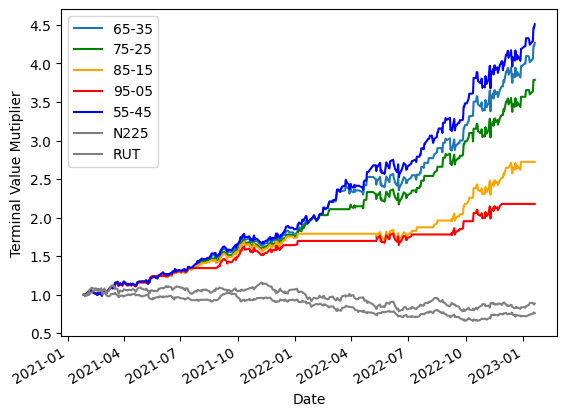

In [70]:
ax = result_test['cumpl'].plot(label='65-35')
result_test2['cumpl'].plot(ax=ax, c='green', label='75-25')
result_test3['cumpl'].plot(ax=ax, c='orange', label='85-15')
result_test4['cumpl'].plot(ax=ax, c='red', label='95-05')
result_test5['cumpl'].plot(ax=ax, c='blue', label='55-45')
ret_test_cpy.X.plot(ax=ax, c='grey', label=f'{feature}')
ret_test_cpy.Y.plot(ax=ax, c='grey', label=f'{target}')
plt.legend(loc='upper left')

plt.xlabel("Date")
plt.ylabel("Terminal Value Mutiplier")